In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, StackingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV, RFE
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.impute import KNNImputer


In [36]:
try:
    df_all = pd.read_csv('certificates2012.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_all = pd.read_csv('certificates2012.csv', encoding='latin-1')
    except UnicodeDecodeError:
        df_all = pd.read_csv('certificates2012.csv', encoding='ISO-8859-1')

# 从数据中随机抽取1000条
df = df_all.sample(n=1000, random_state=42)

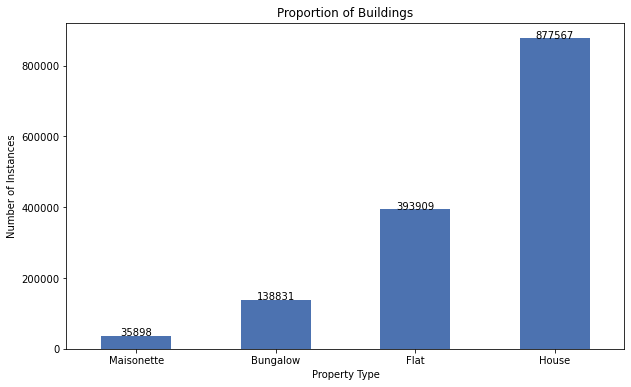

In [37]:
# Assuming df is your DataFrame and it contains a column 'PROPERTY_TYPE'
# Count the occurrences of each property type
property_counts = df_all['PROPERTY_TYPE'].value_counts()

# Reorder to match the order in your example
property_counts = property_counts.reindex(['Maisonette', 'Bungalow', 'Flat', 'House'])
custom_blue = '#4C72B0'  # This is the blue color from the second chart

# Create the bar chart
plt.figure(figsize=(10, 6))
property_counts.plot(kind='bar', color=custom_blue)

# Add labels and title
plt.title('Proportion of Buildings')
plt.xlabel('Property Type')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)


# Annotate each bar with the count
for index, value in enumerate(property_counts):
    plt.text(index, value + 500, str(value), ha='center', fontsize=10)

# Show the plot
plt.show()


WP1:

In [38]:
Unit_Price_GBP_heat = 0.0424
Primary_energy_factor_heat = 1.22
Unit_Price_GBP_electricity = 0.1319
Primary_energy_factor_electricity = 3.07
Energy_Cost_Deflator = 0.42

# Current energy efficiency
total_cost = df['HEATING_COST_CURRENT'] + df['LIGHTING_COST_CURRENT'] + df['HOT_WATER_COST_CURRENT']  
TFA = df['TOTAL_FLOOR_AREA']  

# Calculate ECF
df['ECF'] = Energy_Cost_Deflator * total_cost / (TFA + 45)

# Calculate SAP 2012 based on ECF
df['SAP_2012'] = np.where(df['ECF'] >= 3.5, 
                          117 - 121 * np.log10(df['ECF']), 
                          100 - 13.95 * df['ECF'])

def calculate_epc_rating(sap_rating):
    if sap_rating >= 92:
        return 'A'
    elif sap_rating >= 81:
        return 'B'
    elif sap_rating >= 69:
        return 'C'
    elif sap_rating >= 55:
        return 'D'
    elif sap_rating >= 39:
        return 'E'
    elif sap_rating >= 21:
        return 'F'
    else:
        return 'G'
df['EPC_Rating'] = df['SAP_2012'].apply(calculate_epc_rating)

# Final energy intensity
df['Heating_Final_Energy_Intensity'] = df['HEATING_COST_CURRENT']/(Unit_Price_GBP_heat * df['TOTAL_FLOOR_AREA'])
df['Lighting_Final_Energy_Intensity'] = df['LIGHTING_COST_CURRENT']/(Unit_Price_GBP_electricity * df['TOTAL_FLOOR_AREA'])
df['Hot_Water_Final_Energy_Intensity'] = df['HOT_WATER_COST_CURRENT']/(Unit_Price_GBP_electricity * df['TOTAL_FLOOR_AREA'])


# Primary energy intensity
df['Heating_Primary_Energy_Intensity'] = df['Heating_Final_Energy_Intensity'] * Primary_energy_factor_heat
df['Lighting_Primary_Energy_Intensity'] = df['Lighting_Final_Energy_Intensity'] * Primary_energy_factor_electricity
df['Hot_Water_Primary_Energy_Intensity'] = df['Hot_Water_Final_Energy_Intensity'] * Primary_energy_factor_electricity

df['Energy_Consumption_Current_Cal'] = df['Heating_Primary_Energy_Intensity'] + df['Lighting_Primary_Energy_Intensity'] + df['Hot_Water_Primary_Energy_Intensity']


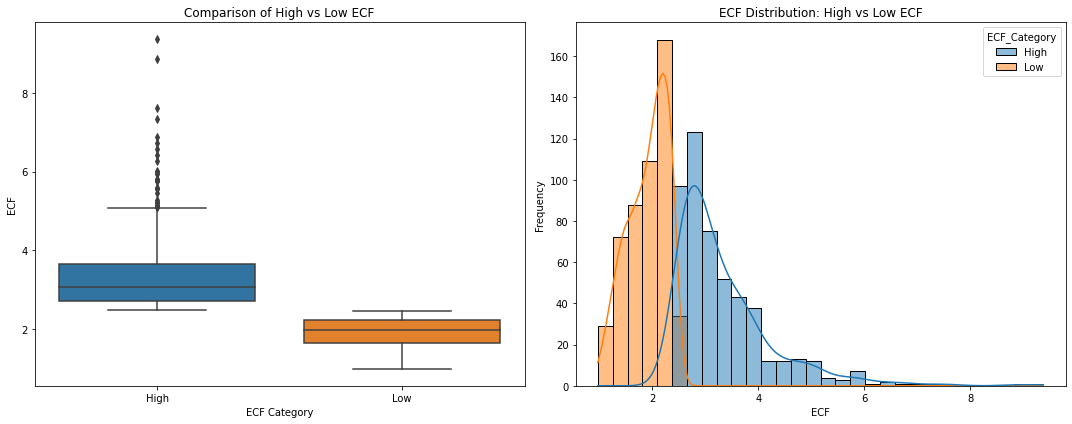

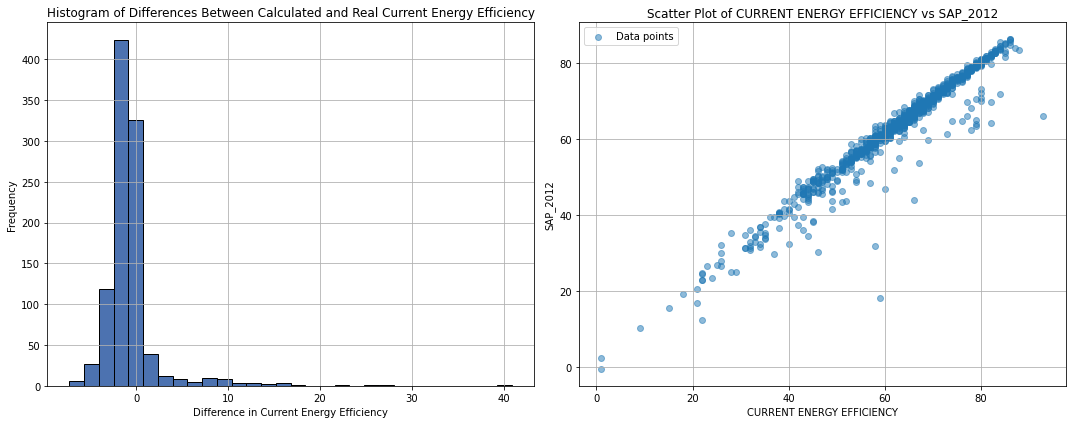

/var/folders/29/_rd3y9h9727dcxd3jvhtp2ch0000gn/T/ipykernel_1257/3335532381.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df['Rating_Difference'] = comparison_df['EPC_Rating'] != comparison_df['CURRENT_ENERGY_RATING']


Rating Differences Count:
False    893
True     107
Name: Rating_Difference, dtype: int64


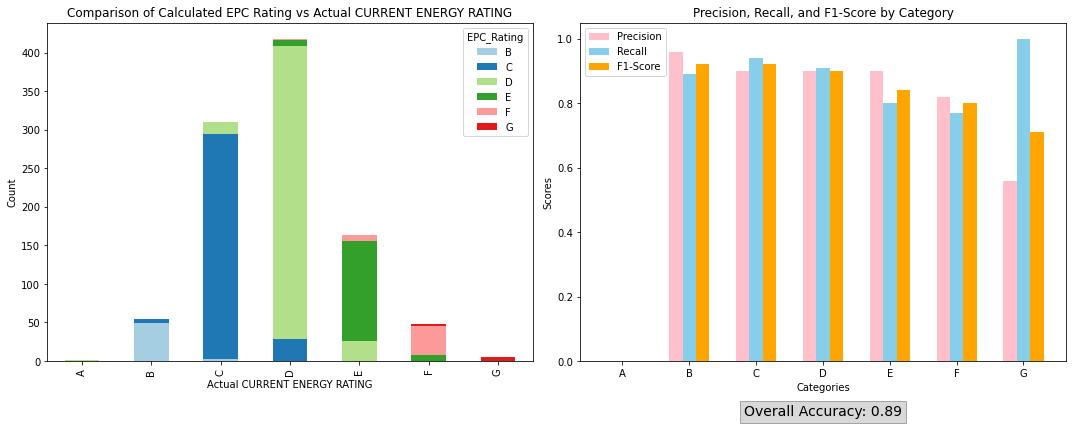

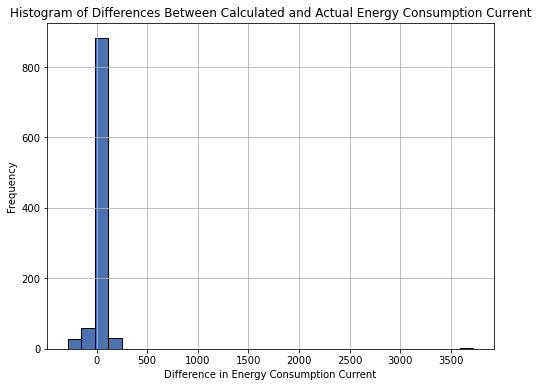

In [39]:
# plot

# Classify the ECF values into high and low categories
# You can define a threshold or use the median to separate high and low ECF
ecf_threshold = df['ECF'].median()
df['ECF_Category'] = df['ECF'].apply(lambda x: 'High' if x > ecf_threshold else 'Low')

# Plotting
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='ECF_Category', y='ECF', data=df)
plt.title('Comparison of High vs Low ECF')
plt.xlabel('ECF Category')
plt.ylabel('ECF')

# Second plot: Histogram
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='ECF', hue='ECF_Category', kde=True, bins=30)
plt.title('ECF Distribution: High vs Low ECF')
plt.xlabel('ECF')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Assuming 'ECF' is the calculated current energy efficiency
# and 'Real_ECF' is the real current energy efficiency stored in your DataFrame.

# Calculate the difference
df['Efficiency_Difference'] = df['CURRENT_ENERGY_EFFICIENCY'] - df['SAP_2012']

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Efficiency_Difference'], bins=30, color='#4C72B0', edgecolor='black')
plt.title('Histogram of Differences Between Calculated and Real Current Energy Efficiency')
plt.xlabel('Difference in Current Energy Efficiency')
plt.ylabel('Frequency')
plt.grid(True)


# 绘制散点图
plt.subplot(1, 2, 2)
plt.scatter(df['CURRENT_ENERGY_EFFICIENCY'], df['SAP_2012'], alpha=0.5, label='Data points')
# 添加图表标题和轴标签
plt.title('Scatter Plot of CURRENT ENERGY EFFICIENCY vs SAP_2012')
plt.xlabel('CURRENT ENERGY EFFICIENCY')
plt.ylabel('SAP_2012')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Step 1: 将计算出的EPC_Rating和CURRENT_ENERGY_RATING放在一个表格中
df['CURRENT_ENERGY_RATING'] = df['CURRENT_ENERGY_RATING'].str.upper()  # 确保一致性
comparison_df = df[['EPC_Rating', 'CURRENT_ENERGY_RATING']]

# Step 2: 计算评级差异
comparison_df['Rating_Difference'] = comparison_df['EPC_Rating'] != comparison_df['CURRENT_ENERGY_RATING']

# 显示评级差异的简单统计
print("Rating Differences Count:")
print(comparison_df['Rating_Difference'].value_counts())

# 生成混淆矩阵
conf_matrix = confusion_matrix(comparison_df['CURRENT_ENERGY_RATING'], comparison_df['EPC_Rating'], labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
# Step 3: 画柱状堆积图
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

comparison_df.groupby(['CURRENT_ENERGY_RATING', 'EPC_Rating']).size().unstack().plot(
    kind='bar', stacked=True, ax=axes[0], color=plt.cm.Paired.colors
)
axes[0].set_title('Comparison of Calculated EPC Rating vs Actual CURRENT ENERGY RATING')
axes[0].set_xlabel('Actual CURRENT ENERGY RATING')
axes[0].set_ylabel('Count')

# Bar plot for precision, recall, and f1-score
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
precision = [0.00, 0.96, 0.90, 0.90, 0.90, 0.82, 0.56]
recall = [0.00, 0.89, 0.94, 0.91, 0.80, 0.77, 1.00]
f1_score = [0.00, 0.92, 0.92, 0.90, 0.84, 0.80, 0.71]

x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

rects1 = axes[1].bar(x - width, precision, width, label='Precision', color='pink')
rects2 = axes[1].bar(x, recall, width, label='Recall', color='skyblue')
rects3 = axes[1].bar(x + width, f1_score, width, label='F1-Score', color='orange')

# Add some text for labels, title, and custom x-axis tick labels, etc.
axes[1].set_xlabel('Categories')
axes[1].set_ylabel('Scores')
axes[1].set_title('Precision, Recall, and F1-Score by Category')

# Add accuracy text directly onto the chart
axes[1].text(0.5, -0.15, 'Overall Accuracy: 0.89', ha='center', va='center', transform=axes[1].transAxes, fontsize=14, bbox=dict(facecolor='grey', alpha=0.3))

axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)
axes[1].legend()

plt.tight_layout()
plt.show()



# 计算差异
df['Energy_Consumption_Current_Difference'] = df['Energy_Consumption_Current_Cal'] - df['ENERGY_CONSUMPTION_CURRENT']
# 检查是否有NaN或非有限值，并将其移除
df = df[np.isfinite(df['Energy_Consumption_Current_Difference'])]
# 确保差异列不为空
if df['Energy_Consumption_Current_Difference'].empty:
    print("No valid data available for plotting.")
else:
    # 绘制直方图
    plt.figure(figsize=(8, 6))
    plt.hist(df['Energy_Consumption_Current_Difference'], bins=30, color='#4C72B0', edgecolor='black')
    plt.title('Histogram of Differences Between Calculated and Actual Energy Consumption Current')
    plt.xlabel('Difference in Energy Consumption Current')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()



WP3:

CURRENT_ENERGY_EFFICIENCY

In [40]:
target = ['CURRENT_ENERGY_EFFICIENCY']

float_columns = ['TOTAL_FLOOR_AREA', 'FLOOR_HEIGHT']
int_columns = ['MULTI_GLAZE_PROPORTION', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS', 'LOW_ENERGY_LIGHTING', 'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT', 'UPRN', 'FLOOR_LEVEL']
variable_columns = ['PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF', 'FLOOR_ENERGY_EFF', 'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF', 'LIGHTING_ENERGY_EFF']
property_type_mapping = {'House': 1, 'Bungalow': 2, 'Maisonette': 3, 'Flat': 4}
df['PROPERTY_TYPE'] = df['PROPERTY_TYPE'].map(property_type_mapping)

# 将列转换为适当的数据类型与缺失值处理
df[float_columns] = df[float_columns].apply(pd.to_numeric, errors='coerce')
df[int_columns] = df[int_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# data conversion
rating_mapping = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Poor': 2, 'Very Poor': 1}
df_mapped = df.copy()
for rm in variable_columns:
    if rm in df_mapped.columns and rm != 'PROPERTY_TYPE':  # 排除已经映射过的 PROPERTY_TYPE 列
        df_mapped[rm] = df_mapped[rm].map(rating_mapping)





# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

df_preprocessed = df_mapped.copy()
df_preprocessed[float_columns + int_columns] = knn_imputer.fit_transform(df_mapped[float_columns + int_columns])


# 将所有需要的列名整合在一起，准备进行相关性分析
selected_columns = float_columns + int_columns + ['PROPERTY_TYPE'] + variable_columns[1:] +['CURRENT_ENERGY_EFFICIENCY'] # 排除变量中的 PROPERTY_TYPE

# 处理 NaN 和 Infinity 值
X = df_preprocessed[selected_columns].drop(columns=['CURRENT_ENERGY_EFFICIENCY']).copy()
y = df_preprocessed['CURRENT_ENERGY_EFFICIENCY'].copy()

# 填充 NaN 值
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# 去除无穷值并替换为 NaN，然后填充
X.replace([np.inf, -np.inf], np.nan, inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)

# 再次填充 NaN 值
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# 检查是否有超出 float32 范围的值，替换为较小的数字
X = X.applymap(lambda x: np.finfo(np.float32).max if x > np.finfo(np.float32).max else x)
X = X.applymap(lambda x: np.finfo(np.float32).min if x < np.finfo(np.float32).min else x)

In [41]:
# Assuming df_preprocessed is your DataFrame
import pandas as pd

# Calculate the statistics for each numeric column
statistics = X = df_preprocessed[selected_columns].describe().T  # Transpose to make it more readable

# Add median to the statistics
statistics['median'] = X = df_preprocessed[selected_columns].median()

# Display the minimum, maximum, average (mean), median, and standard deviation
result = statistics[['min', 'max', 'mean', 'median', 'std']]

# Show the result
print(result)


                              min           max          mean        median  \
TOTAL_FLOOR_AREA              5.3  7.910000e+02  8.774736e+01  7.700000e+01   
FLOOR_HEIGHT                  2.1  3.200000e+00  2.433634e+00  2.412000e+00   
MULTI_GLAZE_PROPORTION        0.0  1.000000e+02  8.291500e+01  1.000000e+02   
NUMBER_HABITABLE_ROOMS        0.0  2.600000e+01  4.020000e+00  4.000000e+00   
NUMBER_HEATED_ROOMS           0.0  2.600000e+01  3.928000e+00  4.000000e+00   
LOW_ENERGY_LIGHTING           0.0  1.000000e+02  4.353000e+01  4.000000e+01   
FIXED_LIGHTING_OUTLETS_COUNT  0.0  1.000000e+02  1.148200e+01  1.000000e+01   
EXTENSION_COUNT               0.0  4.000000e+00  3.770000e-01  0.000000e+00   
UPRN                          0.0  4.220001e+11  6.635009e+10  1.000212e+11   
FLOOR_LEVEL                   0.0  0.000000e+00  0.000000e+00  0.000000e+00   
PROPERTY_TYPE                 1.0  4.000000e+00  1.967000e+00  1.000000e+00   
HOT_WATER_ENERGY_EFF          1.0  5.000000e+00  3.4

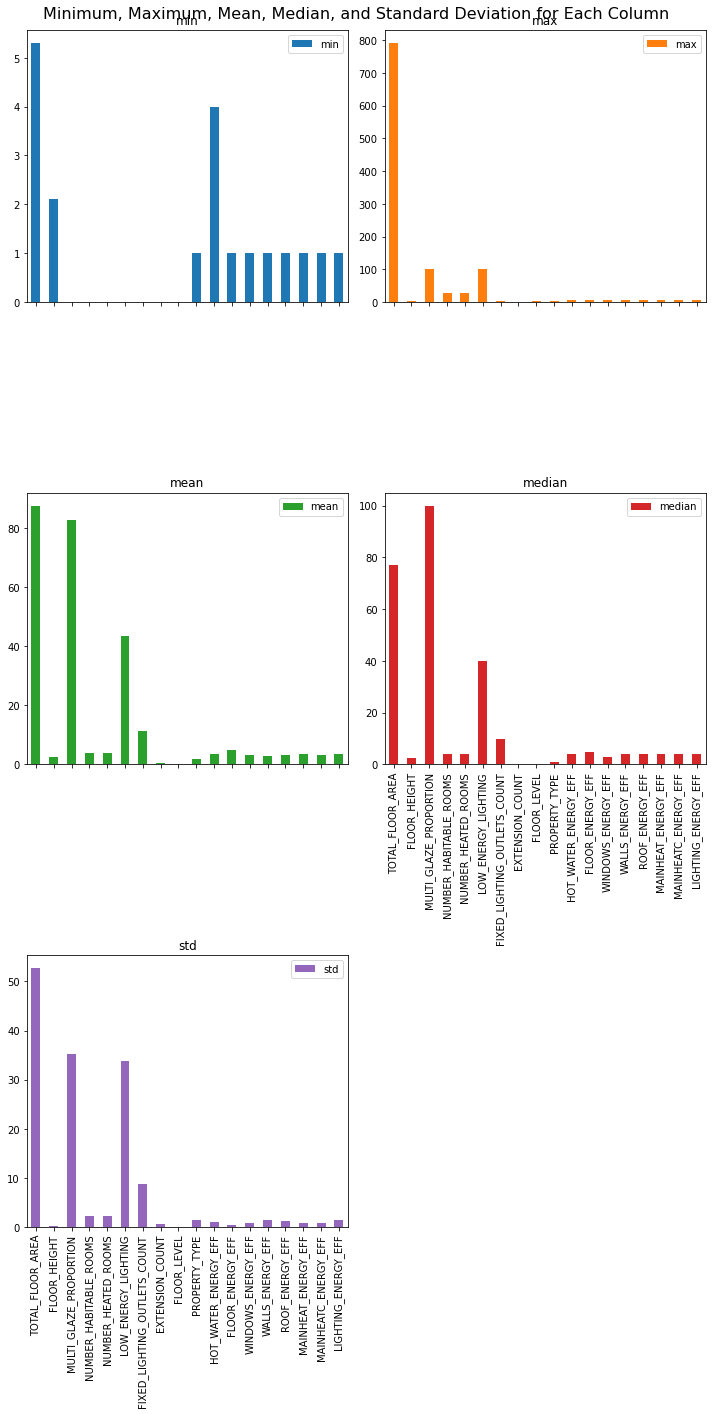

                              min    max   mean  median    std
TOTAL_FLOOR_AREA              5.3  791.0  87.75   77.00  52.73
FLOOR_HEIGHT                  2.1    3.2   2.43    2.41   0.12
MULTI_GLAZE_PROPORTION        0.0  100.0  82.91  100.00  35.15
NUMBER_HABITABLE_ROOMS        0.0   26.0   4.02    4.00   2.17
NUMBER_HEATED_ROOMS           0.0   26.0   3.93    4.00   2.17
LOW_ENERGY_LIGHTING           0.0  100.0  43.53   40.00  33.79
FIXED_LIGHTING_OUTLETS_COUNT  0.0    4.0  11.48   10.00   8.74
EXTENSION_COUNT               0.0    0.0   0.38    0.00   0.69
FLOOR_LEVEL                   0.0    4.0   0.00    0.00   0.00
PROPERTY_TYPE                 1.0    4.0   1.97    1.00   1.32
HOT_WATER_ENERGY_EFF          4.0    5.0   3.47    4.00   0.91
FLOOR_ENERGY_EFF              1.0    5.0   4.76    5.00   0.43
WINDOWS_ENERGY_EFF            1.0    5.0   3.22    3.00   0.89
WALLS_ENERGY_EFF              1.0    5.0   2.94    4.00   1.36
ROOF_ENERGY_EFF               1.0    5.0   3.32    4.00

In [45]:
# Fixing the data to match the index length
data = {
    'min': [5.3, 2.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'max': [791.0, 3.2, 100.0, 26.0, 26.0, 100.0, 4.0, 0.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
    'mean': [87.75, 2.43, 82.91, 4.02, 3.93, 43.53, 11.48, 0.38, 0.0, 1.97, 3.47, 4.76, 3.22, 2.94, 3.32, 3.71, 3.32, 3.38],
    'median': [77.0, 2.41, 100.0, 4.0, 4.0, 40.0, 10.0, 0.0, 0.0, 1.0, 4.0, 5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0],
    'std': [52.73, 0.12, 35.15, 2.17, 2.17, 33.79, 8.74, 0.69, 0.0, 1.32, 0.91, 0.43, 0.89, 1.36, 1.21, 0.71, 0.89, 1.45]
}
index = [
    'TOTAL_FLOOR_AREA', 'FLOOR_HEIGHT', 'MULTI_GLAZE_PROPORTION', 'NUMBER_HABITABLE_ROOMS',
    'NUMBER_HEATED_ROOMS', 'LOW_ENERGY_LIGHTING', 'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT',
    'FLOOR_LEVEL', 'PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF', 'FLOOR_ENERGY_EFF', 'WINDOWS_ENERGY_EFF',
    'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF', 'LIGHTING_ENERGY_EFF'
]
df_stats = pd.DataFrame(data, index=index)

# Plotting the results for each column
df_stats.plot(kind='bar', subplots=True, layout=(3, 2), figsize=(10, 20), sharex=True)

plt.suptitle('Minimum, Maximum, Mean, Median, and Standard Deviation for Each Column', fontsize=16)
plt.tight_layout()
plt.show()



In [46]:
from IPython.display import display

display(df_stats)


,min,max,mean,median,std
TOTAL_FLOOR_AREA,5.3,791.0,87.75,77.00,52.73
FLOOR_HEIGHT,2.1,3.2,2.43,2.41,0.12
MULTI_GLAZE_PROPORTION,0.0,100.0,82.91,100.00,35.15
NUMBER_HABITABLE_ROOMS,0.0,26.0,4.02,4.00,2.17
NUMBER_HEATED_ROOMS,0.0,26.0,3.93,4.00,2.17
LOW_ENERGY_LIGHTING,0.0,100.0,43.53,40.00,33.79
FIXED_LIGHTING_OUTLETS_COUNT,0.0,4.0,11.48,10.00,8.74
EXTENSION_COUNT,0.0,0.0,0.38,0.00,0.69
FLOOR_LEVEL,0.0,4.0,0.00,0.00,0.00
PROPERTY_TYPE,1.0,4.0,1.97,1.00,1.32


In [ ]:
# 数据预处理
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Step 1: 使用Pearson Correlation进行初步特征选择
correlation_threshold = 0.05  # 设定相关系数阈值，选择与目标变量相关性超过该阈值的特征
correlations = pd.Series(np.corrcoef(X_train_scaled.T, y_train_scaled)[-1, :-1], index=X.columns)
selected_features_step1 = correlations[np.abs(correlations) > correlation_threshold].index

X_train_step1 = X_train_scaled[:, X.columns.get_indexer(selected_features_step1)]
X_test_step1 = X_test_scaled[:, X.columns.get_indexer(selected_features_step1)]

print("Selected features after Step 1 (Pearson Correlation):", selected_features_step1)

# Step 2: 使用ElasticNetCV进一步特征选择
elastic_net = ElasticNetCV(cv=10, random_state=42).fit(X_train_step1, y_train_scaled)
selected_features_indices_step2 = np.where(elastic_net.coef_ != 0)[0]
X_train_step2 = X_train_step1[:, selected_features_indices_step2]

selected_features_step2 = selected_features_step1[selected_features_indices_step2]
print("Selected features after Step 2 (ElasticNet):", selected_features_step2)

# Step 3: 使用RFE进行最终特征选择
model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)  # 选择最重要的10个特征
X_train_final = rfe.fit_transform(X_train_step2, y_train_scaled)

selected_features_indices_step3 = np.where(rfe.support_ == True)[0]
selected_features_final = selected_features_step2[selected_features_indices_step3]
print("Selected features after Step 3 (RFE):", selected_features_final)

# 同样处理测试集
X_test_final = X_test_step1[:, selected_features_indices_step2][:, selected_features_indices_step3]




/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Selected features after Step 1 (Pearson Correlation): Index(['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT', 'UPRN',
       'PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF', 'WINDOWS_ENERGY_EFF',
       'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF',
       'MAINHEATC_ENERGY_EFF', 'LIGHTING_ENERGY_EFF'],
      dtype='object')
Selected features after Step 2 (ElasticNet): Index(['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT', 'PROPERTY_TYPE',
       'HOT_WATER_ENERGY_EFF', 'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF',
       'ROOF_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF',
       'LIGHTING_ENERGY_EFF'],
      dtype='object')
Selected features after Step 3 (RFE): Index(['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF',
       'WINDOWS_ENERGY

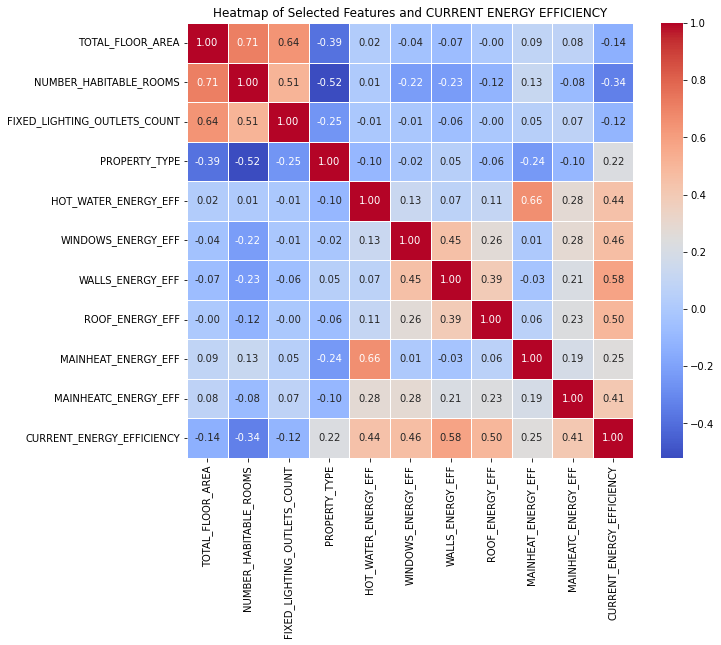

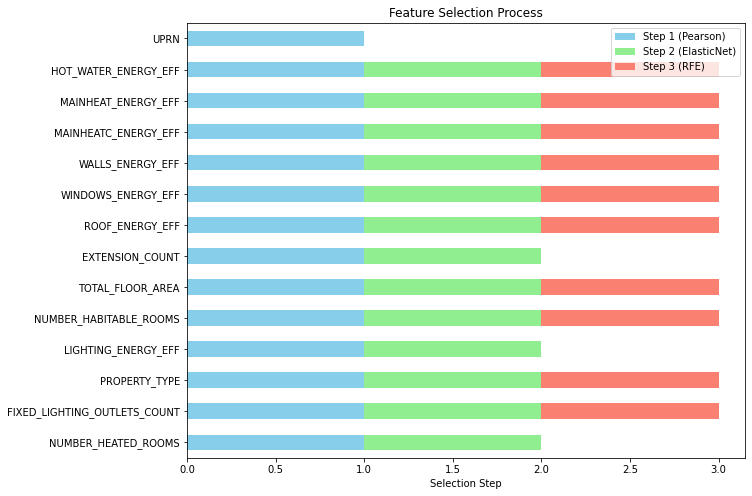

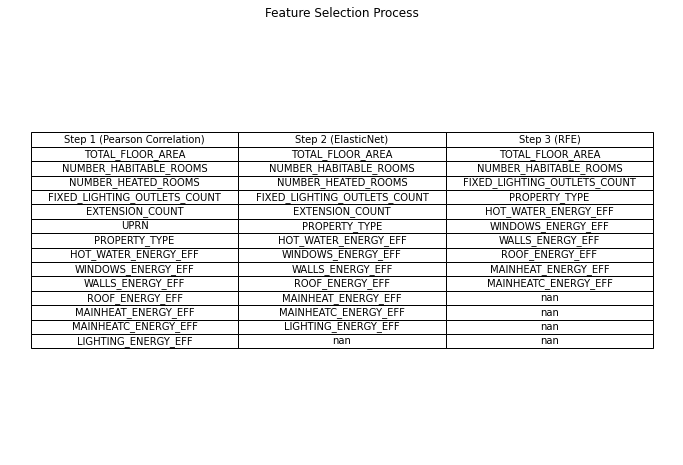

In [ ]:
# 假设 selected_features_final 包含最终选择的10个特征
# 将选出的特征和目标变量合并成一个DataFrame
df_final = pd.concat([X[selected_features_final], y], axis=1)
# 计算相关性矩阵
corr_matrix = df_final.corr()
# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Selected Features and CURRENT ENERGY EFFICIENCY')
plt.show()


# 假设已选择的特征
selected_features_step1 = ['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT', 'UPRN',
       'PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF', 'WINDOWS_ENERGY_EFF',
       'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF',
       'MAINHEATC_ENERGY_EFF', 'LIGHTING_ENERGY_EFF'] # 这是Pearson Correlation选择的特征
selected_features_step2 = ['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT', 'PROPERTY_TYPE',
       'HOT_WATER_ENERGY_EFF', 'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF',
       'ROOF_ENERGY_EFF', 'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF',
       'LIGHTING_ENERGY_EFF']  # 这是ElasticNet选择的特征
selected_features_final = ['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF',
       'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF',
       'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF'] # 这是RFE最终选择的特征


# 创建一个包含所有步骤的DataFrame
all_features = list(set(selected_features_step1 + selected_features_step2 + selected_features_final))
df = pd.DataFrame(0, index=all_features, columns=['Step 1 (Pearson)', 'Step 2 (ElasticNet)', 'Step 3 (RFE)'])

# 标记每个步骤中选择的特征
df.loc[selected_features_step1, 'Step 1 (Pearson)'] = 1
df.loc[selected_features_step2, 'Step 2 (ElasticNet)'] = 1
df.loc[selected_features_final, 'Step 3 (RFE)'] = 1

# 绘制堆叠条形图
df.plot(kind='barh', stacked=True, figsize=(10, 8), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Feature Selection Process')
plt.xlabel('Selection Step')
plt.show()


# 创建一个DataFrame来展示特征选择过程
selection_process = {
    'Step 1 (Pearson Correlation)': selected_features_step1,
    'Step 2 (ElasticNet)': selected_features_step2,
    'Step 3 (RFE)': selected_features_final
}
df_selection = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in selection_process.items()]))

# 使用表格展示特征选择过程
plt.figure(figsize=(12, 8))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=df_selection.values, colLabels=df_selection.columns, cellLoc='center', loc='center')

# 美化表格
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
table.auto_set_column_width(col=list(range(len(df_selection.columns))))

plt.title('Feature Selection Process')
plt.show()

# 假设 selected_features_final 包含最终选择的10个特征
# 将选出的特征和目标变量合并成一个DataFrame
df_final = pd.concat([X[selected_features_final], y], axis=1)

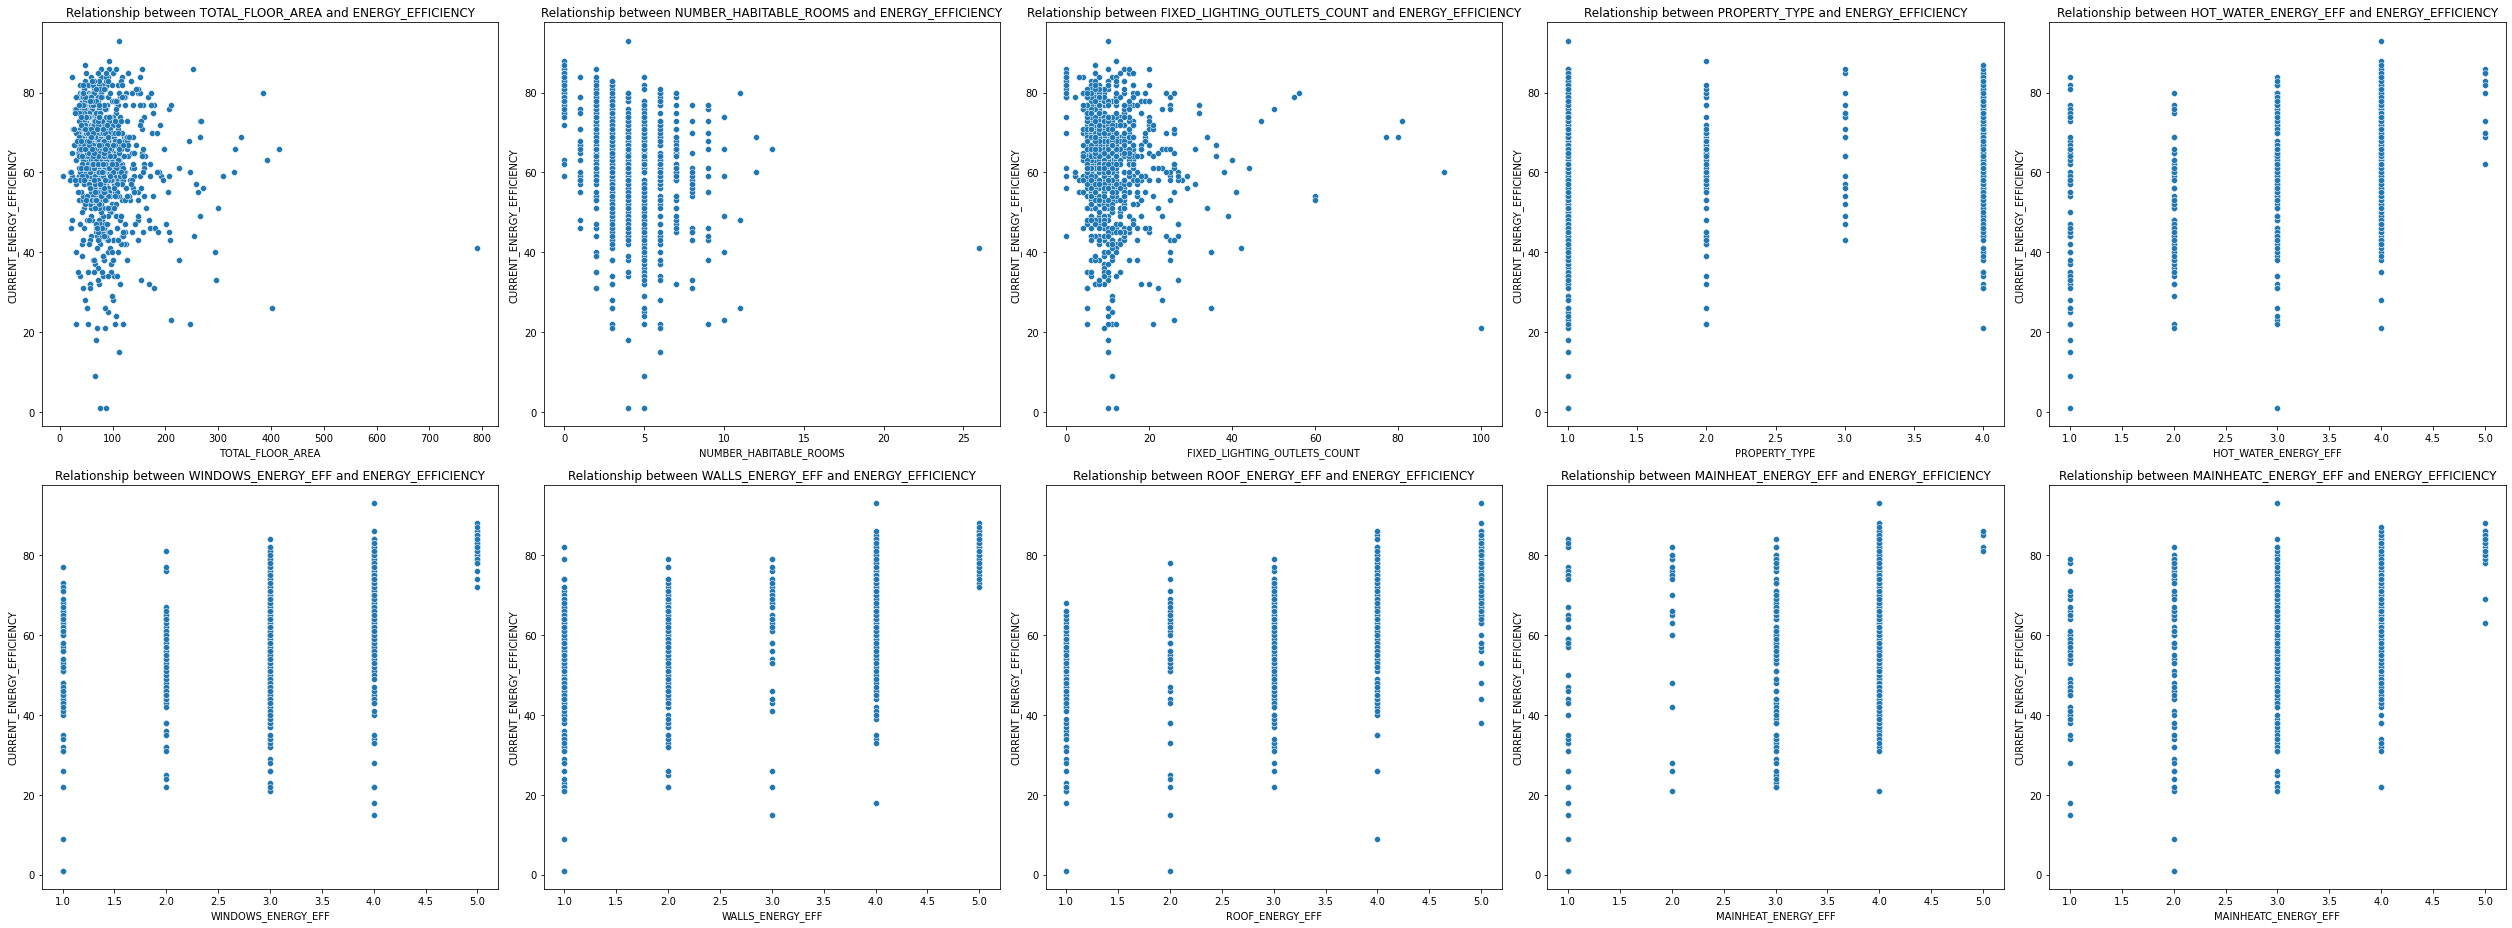

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# selected_features_final是你选择的特征名列表
selected_features_final = ['TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS',
       'FIXED_LIGHTING_OUTLETS_COUNT', 'PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF',
       'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF',
       'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF']

# 创建一个图的网格：2行5列
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(35, 13))  # 可以调整整体图大小

# 遍历每个特征，画在subplot对应位置
for i, feature in enumerate(selected_features_final):
    row, col = i // 5, i % 5
    ax = axes[row, col]
    sns.scatterplot(x=df_preprocessed[feature], y=df_preprocessed['CURRENT_ENERGY_EFFICIENCY'], ax=ax)
    ax.set_title(f'Relationship between {feature} and ENERGY_EFFICIENCY')
    ax.set_xlabel(feature)
    ax.set_ylabel('CURRENT_ENERGY_EFFICIENCY')

# 调整subplot间的间距
plt.tight_layout()
plt.show()


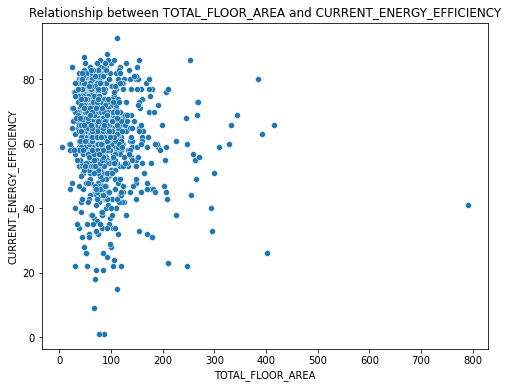

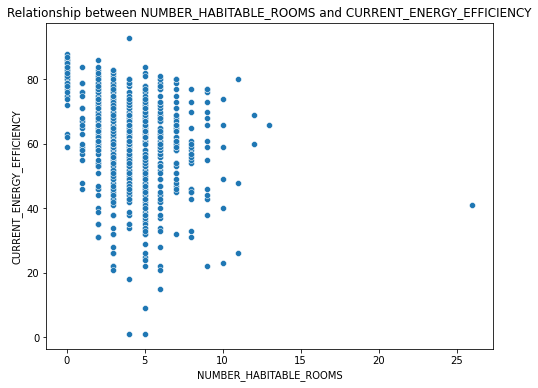

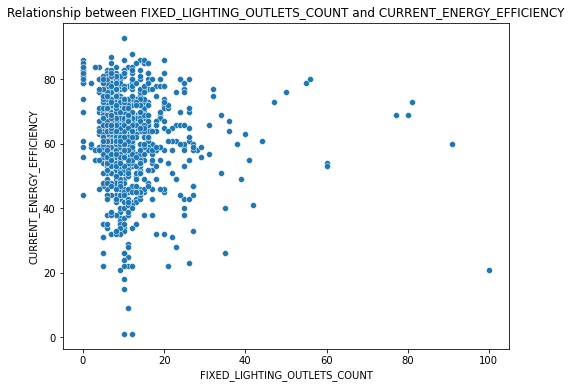

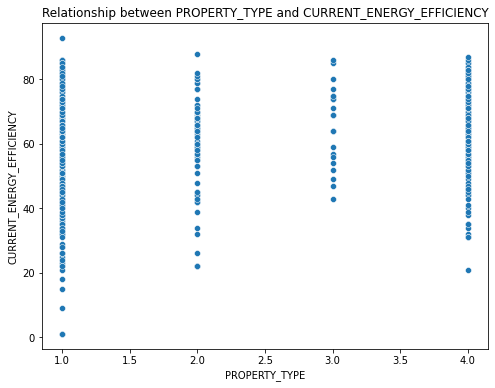

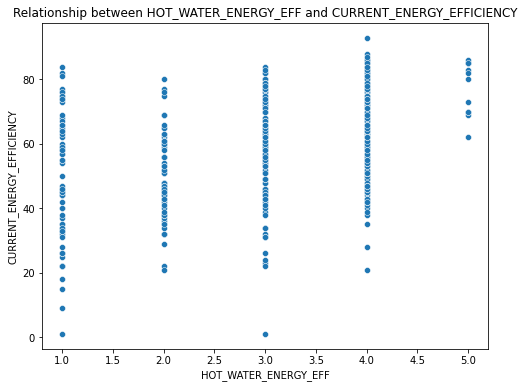

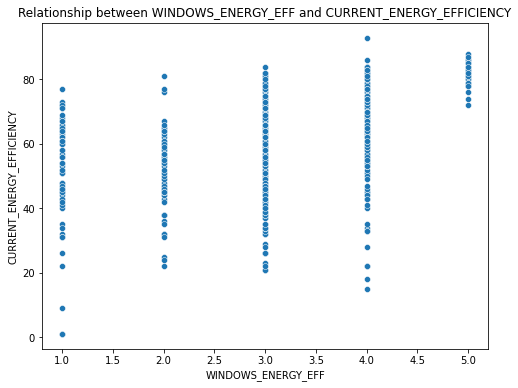

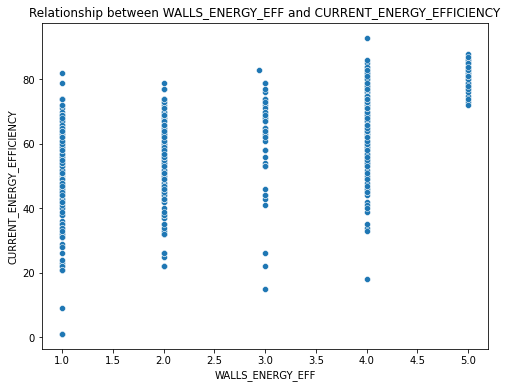

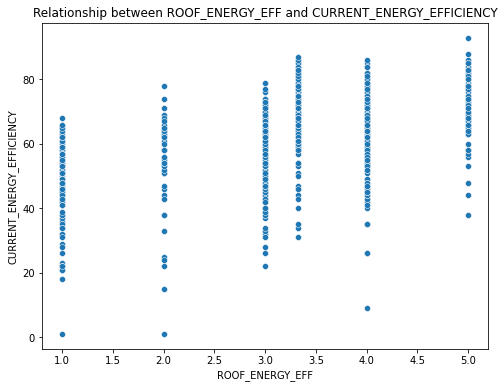

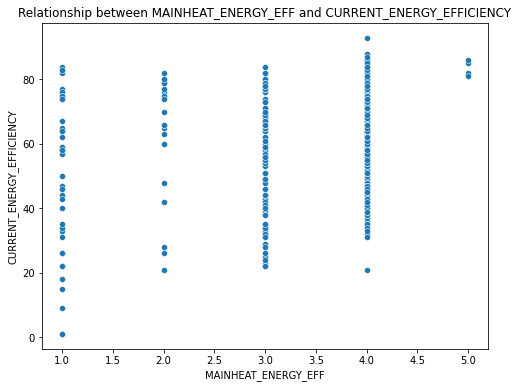

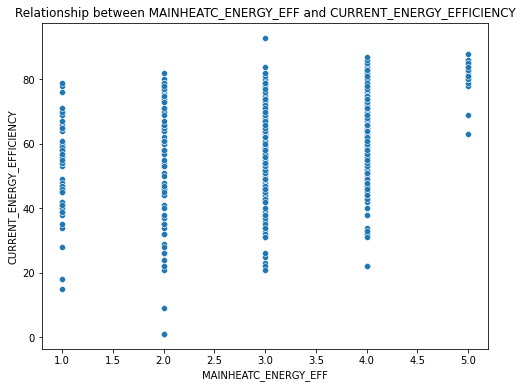

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming selected_features_final is a list of selected feature names
for feature in selected_features_final:
    plt.figure(figsize=(8, 6))
    
    # Scatter plot for continuous variables
    sns.scatterplot(x=df_final[feature], y=df_final['CURRENT_ENERGY_EFFICIENCY'])
    
    plt.title(f'Relationship between {feature} and CURRENT_ENERGY_EFFICIENCY')
    plt.xlabel(feature)
    plt.ylabel('CURRENT_ENERGY_EFFICIENCY')
    plt.show()



for feature in selected_features_final:
    if df[feature].dtype == 'object' or len(df[feature].unique()) < 10:  # Assuming categorical if dtype is object or few unique values
        plt.figure(figsize=(8, 6))
        
        # Bar plot for categorical variables
        sns.barplot(x=df[feature], y=df['CURRENT_ENERGY_EFFICIENCY'], ci=None)
        
        plt.title(f'Relationship between {feature} and CURRENT_ENERGY_EFFICIENCY')
        plt.xlabel(feature)
        plt.ylabel('CURRENT_ENERGY_EFFICIENCY')
        plt.show()


In [ ]:
# 使用Random Forest进行预测
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_scaled)
y_pred_rf = rf_model.predict(X_test_final)

# 使用BP神经网络进行预测
bp_model = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42)
bp_model.fit(X_train_final, y_train_scaled)
y_pred_bp = bp_model.predict(X_test_final)

# 计算方差-协方差加权融合
var_rf = np.var(y_pred_rf)
var_bp = np.var(y_pred_bp)

weight_rf = var_bp / (var_rf + var_bp)
weight_bp = var_rf / (var_rf + var_bp)

y_pred_combined_rfbp = weight_rf * y_pred_rf + weight_bp * y_pred_bp
y_pred_combined_rfbp = scaler_y.inverse_transform(y_pred_combined_rfbp.reshape(-1, 1)).ravel()

# 评估模型性能
y_test_actual_rfbp = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

rmse_rfbp = round(mean_squared_error(y_test_actual_rfbp, y_pred_combined_rfbp, squared=False),3)
r2_rfbp = round(r2_score(y_test_actual_rfbp, y_pred_combined_rfbp),3)
mae_rfbp = round(mean_absolute_error(y_test_actual_rfbp, y_pred_combined_rfbp),3)
mse_rfbp = round(mean_squared_error(y_test_actual_rfbp, y_pred_combined_rfbp), 3)
mape_rfbp = round(mean_absolute_percentage_error(y_test_actual_rfbp, y_pred_combined_rfbp), 3)

accuracy_rfbp = round(np.mean(np.round(y_test_actual_rfbp) == np.round(y_pred_combined_rfbp)),3)

# 打印评估结果
print(f'RMSE(RF+BPNN): {rmse_rfbp}')
print(f'R²(RF+BPNN): {r2_rfbp}')
print(f'MAE(RF+BPNN): {mae_rfbp}')
print(f'Accuracy(RF+BPNN): {accuracy_rfbp}')
print(f'MSE(RF+BPNN): {mse_rfbp}')
print(f'MAPE(RF+BPNN): {mape_rfbp}')

RMSE(RF+BPNN): 6.898
R²(RF+BPNN): 0.787
MAE(RF+BPNN): 5.275
Accuracy(RF+BPNN): 0.03
MSE(RF+BPNN): 47.584
MAPE(RF+BPNN): 0.117


/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# 使用多个模型进行预测

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train_final, y_train_scaled)
y_pred_xgb = xgb_model.predict(X_test_final)

lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lgb_model.fit(X_train_final, y_train_scaled)
y_pred_lgb = lgb_model.predict(X_test_final)

# 计算方差-协方差加权融合

var_xgb = np.var(y_pred_xgb)
var_lgb = np.var(y_pred_lgb)

total_variance = var_xgb + var_lgb
weight_xgb = var_lgb / total_variance 
weight_lgb = var_xgb / total_variance 

y_pred_combined_xgblgb = (weight_xgb * y_pred_xgb + weight_lgb * y_pred_lgb)
y_pred_combined_xgblgb = scaler_y.inverse_transform(y_pred_combined_xgblgb.reshape(-1, 1)).ravel()

# 评估模型性能
y_test_actual_xgblgb = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

rmse_xgblgb = round(mean_squared_error(y_test_actual_xgblgb, y_pred_combined_xgblgb, squared=False),3)
r2_xgblgb = round(r2_score(y_test_actual_xgblgb, y_pred_combined_xgblgb),3)
mae_xgblgb = round(mean_absolute_error(y_test_actual_xgblgb, y_pred_combined_xgblgb),3)
accuracy_xgblgb = round(np.mean(np.round(y_test_actual_xgblgb) == np.round(y_pred_combined_xgblgb)),3)
mse_xgblgb = round(mean_squared_error(y_test_actual_xgblgb, y_pred_combined_xgblgb), 3)
mape_xgblgb = round(mean_absolute_percentage_error(y_test_actual_xgblgb, y_pred_combined_xgblgb), 3)

# 打印评估结果
print(f'RMSE(XGB+LGB): {rmse_xgblgb}')
print(f'R²(XGB+LGB): {r2_xgblgb}')
print(f'MAE(XGB+LGB): {mae_xgblgb}')
print(f'Accuracy(XGB+LGB): {accuracy_xgblgb}')
print(f'MSE(XGB+LGB)): {mse_xgblgb}')
print(f'MAPE(XGB+LGB)): {mape_xgblgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:

# 使用SVR进行预测
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_final, y_train_scaled)
y_pred_svr = svr_model.predict(X_test_final)

# 使用人工神经网络（ANN）进行预测
ann_model = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42)
ann_model.fit(X_train_final, y_train_scaled)
y_pred_ann = ann_model.predict(X_test_final)

# 计算方差-协方差加权融合
var_svr = np.var(y_pred_svr)
var_ann = np.var(y_pred_ann)

weight_svr = var_ann / (var_svr + var_ann)
weight_ann = var_svr / (var_svr + var_ann)

y_pred_combined_svrann = weight_svr * y_pred_svr + weight_ann * y_pred_ann
y_pred_combined_svrann = scaler_y.inverse_transform(y_pred_combined_svrann.reshape(-1, 1)).ravel()

# 评估模型性能
y_test_actual_svrann = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

rmse_svrann = round(mean_squared_error(y_test_actual_svrann, y_pred_combined_svrann, squared=False),3)
r2_svrann = round(r2_score(y_test_actual_svrann, y_pred_combined_svrann),3)
mae_svrann = round(mean_absolute_error(y_test_actual_svrann, y_pred_combined_svrann),3)
accuracy_svrann = round(np.mean(np.round(y_test_actual_svrann) == np.round(y_pred_combined_svrann)),3)
mse_svrann = round(mean_squared_error(y_test_actual_svrann, y_pred_combined_svrann), 3)
mape_svrann = round(mean_absolute_percentage_error(y_test_actual_svrann, y_pred_combined_svrann), 3)

# 打印评估结果
print(f'RMSE(SVR+ANN): {rmse_svrann}')
print(f'R²(SVR+ANN): {r2_svrann}')
print(f'MAE(SVR+ANN): {mae_svrann}')
print(f'Accuracy(SVR+ANN): {accuracy_svrann}')
print(f'MSE(SVR+ANN): {mse_svrann}')
print(f'MAPE(SVR+ANN): {mape_svrann}')

RMSE(SVR+ANN): 7.054
R²(SVR+ANN): 0.777
MAE(SVR+ANN): 5.291
Accuracy(SVR+ANN): 0.045
MSE(SVR+ANN): 49.763
MAPE(SVR+ANN): 0.121


/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import pandas as pd
data = {'Model': ['RF+BPNN', 'XGB+LGB', 'SVR+ANN'],
    'R²': [r2_rfbp, r2_xgblgb, r2_svrann],
    'MAE': [mae_rfbp, mae_xgblgb, mae_svrann],
    'RMSE': [rmse_rfbp, rmse_xgblgb, rmse_svrann],
    'MSE': [mse_rfbp, mse_xgblgb, mse_svrann],
    'MAPE': [mape_rfbp, mape_xgblgb, mape_svrann]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the Model column as the index
df.set_index('Model', inplace=True)

# Display the DataFrame
df




,R²,MAE,RMSE,MSE,MAPE
Model,,,,,
RF+BPNN,0.787,5.275,6.898,47.584,0.117
XGB+LGB,0.826,4.609,6.236,38.890,0.102
SVR+ANN,0.777,5.291,7.054,49.763,0.121


In [ ]:
def yu(sap_rating):
    if sap_rating >= 92:
        return 'A'
    elif sap_rating >= 81:
        return 'B'
    elif sap_rating >= 69:
        return 'C'
    elif sap_rating >= 55:
        return 'D'
    elif sap_rating >= 39:
        return 'E'
    elif sap_rating >= 21:
        return 'F'
    else:
        return 'G'

# Calculate the predicted EPC ratings
predicted_ratings_svrann = np.array([calculate_epc_rating(sap) for sap in y_pred_combined_svrann])
# Ensure the actual ratings are aligned with the predicted ratings
actual_ratings = df_preprocessed['CURRENT_ENERGY_RATING'].iloc[:len(predicted_ratings_svrann)].values
# Calculate the accuracy by comparing the predicted ratings to the actual ratings
accuracy_svrann = np.mean(predicted_ratings_svrann == actual_ratings)
# Output the accuracy
print(f"Accuracy(svr+ann): {accuracy_svrann * 100:.2f}%")

# Calculate the predicted EPC ratings
predicted_ratings_xgblgb = np.array([calculate_epc_rating(sap) for sap in y_pred_combined_xgblgb])
# Ensure the actual ratings are aligned with the predicted ratings
actual_ratings = df_preprocessed['CURRENT_ENERGY_RATING'].iloc[:len(predicted_ratings_xgblgb)].values
# Calculate the accuracy by comparing the predicted ratings to the actual ratings
accuracy_xgblgb = np.mean(predicted_ratings_xgblgb == actual_ratings)
# Output the accuracy
print(f"Accuracy(xgblgb): {accuracy_xgblgb * 100:.2f}%")

# Calculate the predicted EPC ratings
predicted_ratings_rfbp = np.array([calculate_epc_rating(sap) for sap in y_pred_combined_rfbp])
# Ensure the actual ratings are aligned with the predicted ratings
actual_ratings = df_preprocessed['CURRENT_ENERGY_RATING'].iloc[:len(predicted_ratings_rfbp)].values
# Calculate the accuracy by comparing the predicted ratings to the actual ratings
accuracy_rfbp = np.mean(predicted_ratings_rfbp == actual_ratings)
# Output the accuracy
print(f"Accuracy(rf+bpnn): {accuracy_rfbp * 100:.2f}%")




Accuracy(svr+ann): 25.00%
Accuracy(xgblgb): 27.00%
Accuracy(rf+bpnn): 25.50%


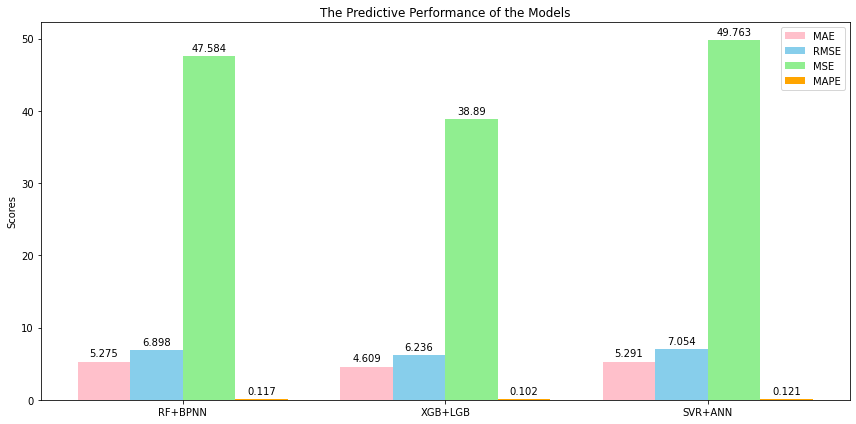

In [ ]:
models = ['RF+BPNN', 'XGB+LGB', 'SVR+ANN']
mae_scores = [mae_rfbp, mae_xgblgb, mae_svrann]  
rmse_scores = [rmse_rfbp, rmse_xgblgb, rmse_svrann]
mse_scores = [mse_rfbp, mse_xgblgb, mse_svrann]  
mape_scores = [mape_rfbp, mape_xgblgb, mape_svrann]

x = np.arange(len(models))  # 模型的位置
width = 0.2  # 每个柱子的宽度

fig, ax = plt.subplots(figsize=(12, 6))

# 绘制 MAE, RMSE, MSE, MAPE 的柱状图
rects1 = ax.bar(x - 1.5 * width, mae_scores, width, label='MAE', color='pink')
rects2 = ax.bar(x - 0.5 * width, rmse_scores, width, label='RMSE', color='skyblue')
rects3 = ax.bar(x + 0.5 * width, mse_scores, width, label='MSE', color='lightgreen')
rects4 = ax.bar(x + 1.5 * width, mape_scores, width, label='MAPE', color='orange')

# 添加一些文本标签
ax.set_ylabel('Scores')
ax.set_title('The Predictive Performance of the Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 添加数据标签
def autolabel(rects):
    """在每个柱子顶部显示其高度."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()


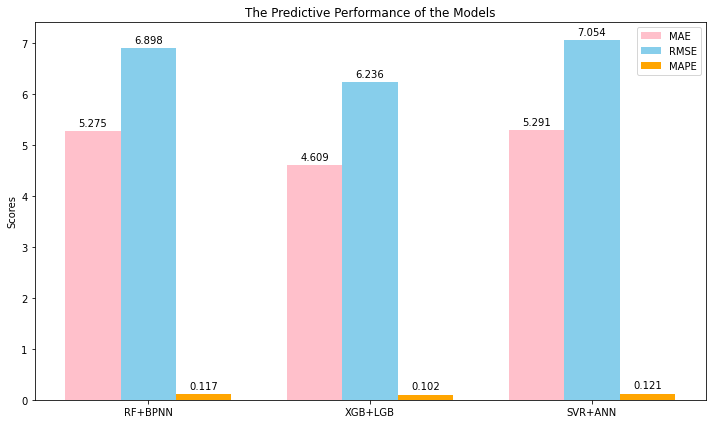

In [ ]:
models = ['RF+BPNN', 'XGB+LGB', 'SVR+ANN']
mae_scores = [mae_rfbp, mae_xgblgb, mae_svrann]  
rmse_scores = [rmse_rfbp, rmse_xgblgb, rmse_svrann]
mape_scores = [mape_rfbp, mape_xgblgb, mape_svrann]

x = np.arange(len(models))  # 模型的位置
width = 0.25  # 每个柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制 MAE, RMSE, MAPE 的柱状图
rects1 = ax.bar(x - width, mae_scores, width, label='MAE', color='pink')
rects2 = ax.bar(x, rmse_scores, width, label='RMSE', color='skyblue')
rects3 = ax.bar(x + width, mape_scores, width, label='MAPE', color='orange')

# 添加一些文本标签
ax.set_ylabel('Scores')
ax.set_title('The Predictive Performance of the Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 添加数据标签
def autolabel(rects):
    """在每个柱子顶部显示其高度."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()


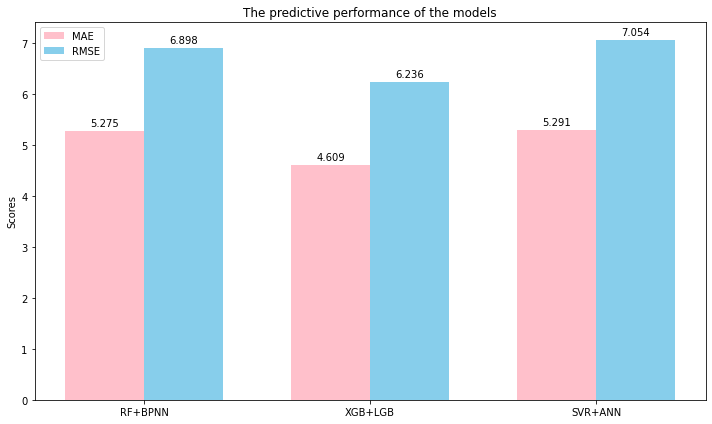

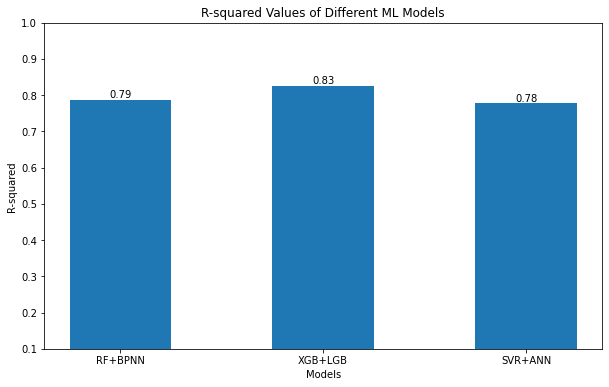

In [ ]:
models = ['RF+BPNN', 'XGB+LGB', 'SVR+ANN']
mae_scores = [mae_rfbp, mae_xgblgb, mae_svrann]  
rmse_scores = [rmse_rfbp, rmse_xgblgb, rmse_svrann]


x = np.arange(len(models))  # 模型的位置
width = 0.35  # 柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制 MAE 和 RMSE 的柱状图
rects1 = ax.bar(x - width/2, mae_scores, width, label='MAE', color='pink')
rects2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE', color='skyblue')

# 添加一些文本标签
ax.set_ylabel('Scores')
ax.set_title('The predictive performance of the models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 添加数据标签
def autolabel(rects):
    """在每个柱子顶部显示其高度."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()




models = ['RF+BPNN', 'XGB+LGB', 'SVR+ANN']
r_squared = [r2_rfbp, r2_xgblgb, r2_svrann]
# 创建柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(models, r_squared, width=0.5)
# 添加标签
plt.xlabel('Models')
plt.ylabel('R-squared')
plt.title('R-squared Values of Different ML Models')
plt.ylim(0.1, 1.0)  # 设置y轴范围
# 为每个柱子添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom')
# 显示图表
plt.show()

EPC Letter

/var/folders/29/_rd3y9h9727dcxd3jvhtp2ch0000gn/T/ipykernel_1257/4051288442.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


Logistic Regression - Balanced Accuracy: 0.50
Logistic Regression - F1 Score: 0.64
Accuracy: 0.65
Confusion Matrix:
[[11  3  0  0  0  0]
 [ 2 47  9  0  0  0]
 [ 0 20 57  4  0  0]
 [ 0  0 18 11  3  0]
 [ 0  0  1  7  4  0]
 [ 0  0  0  0  3  0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.79      0.81        14
           2       0.67      0.81      0.73        58
           3       0.67      0.70      0.69        81
           4       0.50      0.34      0.41        32
           5       0.40      0.33      0.36        12
           6       0.00      0.00      0.00         3

    accuracy                           0.65       200
   macro avg       0.51      0.50      0.50       200
weighted avg       0.63      0.65      0.64       200



/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

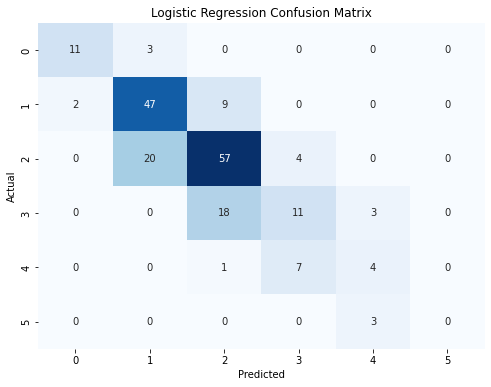

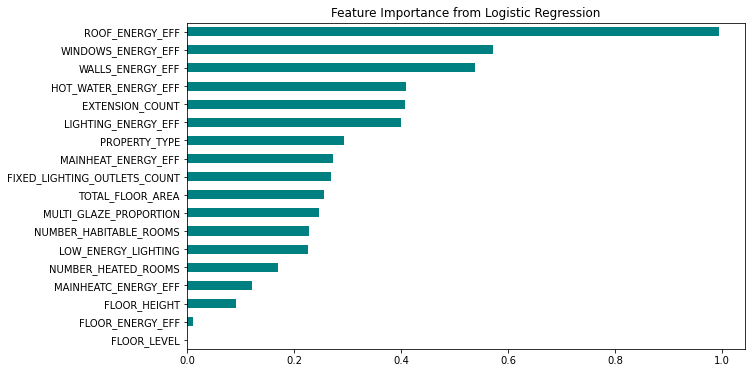

In [ ]:

# 读取数据
try:
    df_all = pd.read_csv('certificates2012.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_all = pd.read_csv('certificates2012.csv', encoding='latin-1')
    except UnicodeDecodeError:
        df_all = pd.read_csv('certificates2012.csv', encoding='ISO-8859-1')

# 从数据中随机抽取1000条
df = df_all.sample(n=1000, random_state=42)

target = 'CURRENT_ENERGY_RATING'
float_columns = ['TOTAL_FLOOR_AREA', 'FLOOR_HEIGHT']
int_columns = ['MULTI_GLAZE_PROPORTION', 'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',  'LOW_ENERGY_LIGHTING', 'FIXED_LIGHTING_OUTLETS_COUNT', 'EXTENSION_COUNT', 'FLOOR_LEVEL']
variable_columns = ['PROPERTY_TYPE', 'HOT_WATER_ENERGY_EFF', 'FLOOR_ENERGY_EFF',  'WINDOWS_ENERGY_EFF', 'WALLS_ENERGY_EFF', 'ROOF_ENERGY_EFF',  'MAINHEAT_ENERGY_EFF', 'MAINHEATC_ENERGY_EFF', 'LIGHTING_ENERGY_EFF']

# 映射 PROPERTY_TYPE 列
property_type_mapping = {'House': 1, 'Bungalow': 2, 'Maisonette': 3, 'Flat': 4}
df['PROPERTY_TYPE'] = df['PROPERTY_TYPE'].map(property_type_mapping)

# 将列转换为适当的数据类型
df[float_columns] = df[float_columns].apply(pd.to_numeric, errors='coerce')
df[int_columns] = df[int_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# 映射变量列
rating_mapping = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Poor': 2, 'Very Poor': 1}
for col in variable_columns:
    if col != 'PROPERTY_TYPE':
        df[col] = df[col].map(rating_mapping)


# 处理 NaN 和 Infinity 值
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)

# 编码目标变量
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

# 特征选择
selected_columns = float_columns + int_columns + ['PROPERTY_TYPE'] + variable_columns[1:]

# 划分训练集和测试集
X = df[selected_columns]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练Logistic Regression模型
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 预测
y_pred = log_reg.predict(X_test_scaled)


# 确保正确导入
from sklearn.metrics import f1_score

# 评估模型
log_reg_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
log_reg_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
log_reg_f1 = f1_score(y_test, y_pred, average='weighted')




print(f"Logistic Regression - Balanced Accuracy: {log_reg_balanced_accuracy:.2f}")
print(f"Logistic Regression - F1 Score: {log_reg_f1:.2f}")
print(f"Accuracy: {log_reg_accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# 绘制逻辑回归的混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 提取逻辑回归模型的特征权重
feature_importances_lr = pd.Series(abs(log_reg.coef_[0]), index=selected_columns)

# 绘制特征重要性条形图
plt.figure(figsize=(10, 6))
feature_importances_lr.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance from Logistic Regression')
plt.show()


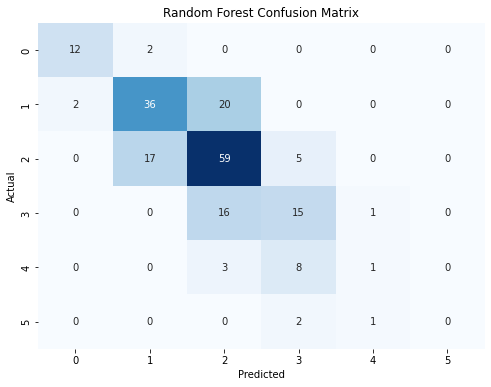

Random Forest - Balanced Accuracy: 0.46
Random Forest - F1 Score: 0.60
Random Forest Model Accuracy: 0.61


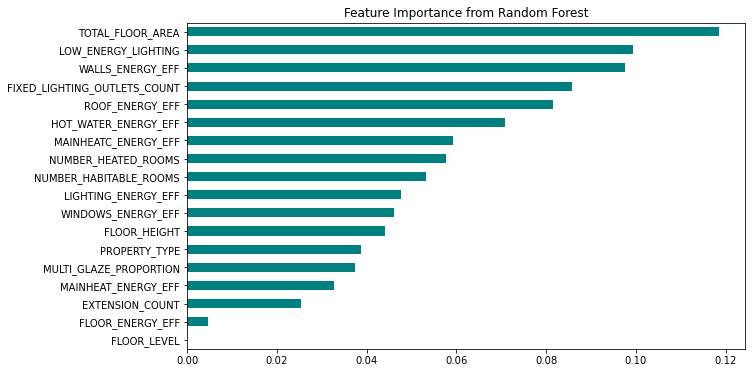

In [ ]:
# 使用Random Forest模型进行预测 (假设模型已经训练完毕，且有预测结果y_pred_rf)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)
y_pred_rf = rf_clf.predict(X_test_scaled)

# 绘制混淆矩阵
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 计算并显示模型的准确度
accuracy_rf = accuracy_score(y_test, y_pred_rf)
rf_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')


print(f"Random Forest - Balanced Accuracy: {rf_balanced_accuracy:.2f}")
print(f"Random Forest - F1 Score: {rf_f1:.2f}")
print(f"Random Forest Model Accuracy: {accuracy_rf:.2f}")

# 计算特征重要性并绘制图表
feature_importances_rf = pd.Series(rf_clf.feature_importances_, index=selected_columns)

plt.figure(figsize=(10, 6))
feature_importances_rf.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance from Random Forest')
plt.show()


/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1415: RuntimeWarning: Number of classes in training fold (6) does not match total number of classes (7). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1415: RuntimeWarning: Number of classes in training fold (6) does not match total number of classes (7). Results may not be

Stacking Classifier - Balanced Accuracy: 0.53
Stacking Classifier - F1 Score: 0.69
Stacking Classifier Accuracy: 0.7
Stacking Classifier Confusion Matrix:
[[11  3  0  0  0  0]
 [ 1 47 10  0  0  0]
 [ 0 18 60  3  0  0]
 [ 0  0 12 19  1  0]
 [ 0  0  2  7  3  0]
 [ 0  0  0  2  1  0]]
Stacking Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.79      0.85        14
           2       0.69      0.81      0.75        58
           3       0.71      0.74      0.73        81
           4       0.61      0.59      0.60        32
           5       0.60      0.25      0.35        12
           6       0.00      0.00      0.00         3

    accuracy                           0.70       200
   macro avg       0.59      0.53      0.55       200
weighted avg       0.69      0.70      0.69       200



/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yangxuehan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

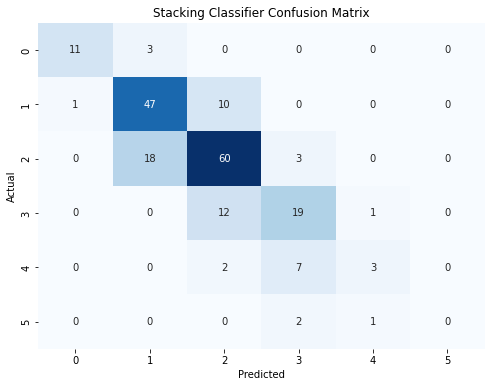

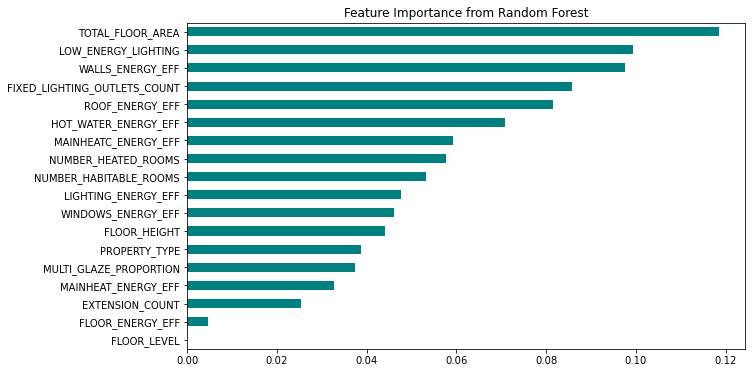

In [ ]:

# 编码目标变量
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

# 特征选择
selected_columns = float_columns + int_columns + ['PROPERTY_TYPE'] + variable_columns[1:]

# 划分训练集和测试集
X = df[selected_columns]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建单独的模型
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
# 创建堆叠分类器
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('svm', svm_clf)
    ],
    final_estimator=LogisticRegression()
)

# 训练堆叠分类器
stacking_clf.fit(X_train_scaled, y_train)

# 预测
y_pred_stacking = stacking_clf.predict(X_test_scaled)

# 评估模型
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
class_report_stacking = classification_report(y_test, y_pred_stacking)
stacking_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_stacking)
stacking_f1 = f1_score(y_test, y_pred_stacking, average='weighted')

print(f"Stacking Classifier - Balanced Accuracy: {stacking_balanced_accuracy:.2f}")
print(f"Stacking Classifier - F1 Score: {stacking_f1:.2f}")
print(f"Stacking Classifier Accuracy: {accuracy_stacking}")
print(f"Stacking Classifier Confusion Matrix:\n{conf_matrix_stacking}")
print(f"Stacking Classifier Classification Report:\n{class_report_stacking}")


# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Stacking Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 从随机森林中提取特征重要性
rf_clf.fit(X_train, y_train)
feature_importances = pd.Series(rf_clf.feature_importances_, index=selected_columns)

plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance from Random Forest')
plt.show()



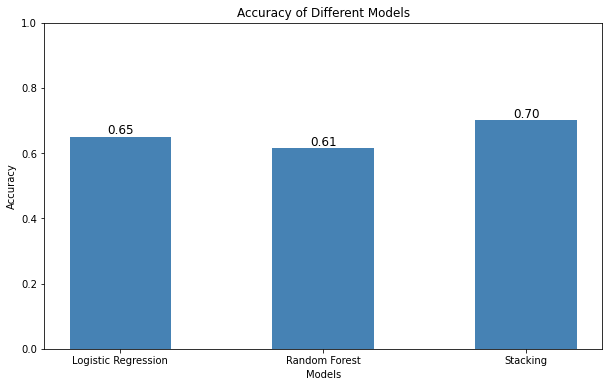

In [ ]:

# 模型名称和对应的accuracy
models = ['Logistic Regression', 'Random Forest', 'Stacking']
accuracies = [log_reg_accuracy, accuracy_rf, accuracy_stacking]

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='steelblue', width=0.5)

# 添加数值标签
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12)

# 添加标题和标签
plt.title('Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # 设置y轴范围为0到1
plt.show()


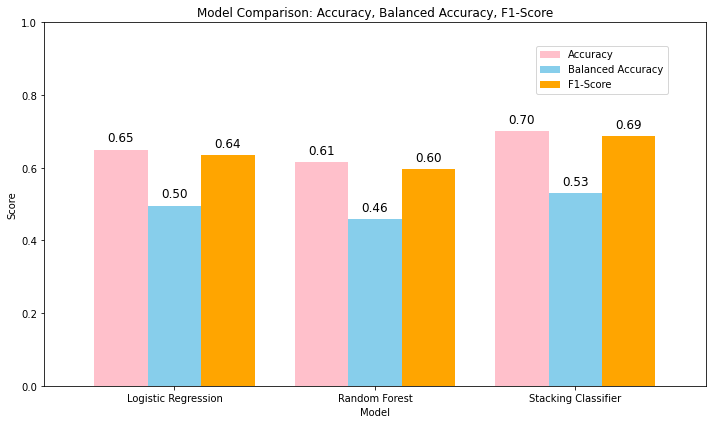

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following values have been computed for each model:
log_reg_metrics = {
    'Accuracy': log_reg_accuracy,
    'Balanced Accuracy': log_reg_balanced_accuracy,
    'F1-Score': log_reg_f1,
}

rf_metrics = {
    'Accuracy': accuracy_rf,
    'Balanced Accuracy': rf_balanced_accuracy,
    'F1-Score': rf_f1,
}

stacking_metrics = {
    'Accuracy': accuracy_stacking,
    'Balanced Accuracy': stacking_balanced_accuracy,
    'F1-Score': stacking_f1,
}

# Combine all metrics into a DataFrame
metrics_df = pd.DataFrame({
    'Logistic Regression': log_reg_metrics,
    'Random Forest': rf_metrics,
    'Stacking Classifier': stacking_metrics
})

# Transpose the DataFrame for easier plotting
metrics_df = metrics_df.T

# Define the colors for each metric
colors = ['pink', 'skyblue', 'orange']

# Plotting the bar chart

ax = metrics_df.plot(kind='bar', figsize=(10, 6), width=0.8, color=colors)

# Adding titles and labels
ax.set_title('Model Comparison: Accuracy, Balanced Accuracy, F1-Score')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)  # Since the metrics are between 0 and 1

# Setting x-tick labels with rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Adding the legend inside the plot
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), frameon=True)

# Add value labels within the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=12, padding=5)

# Display the plot
plt.tight_layout()
plt.show()